# Project Double DQN Agent

Name: Gary Sampson

In [1]:
from __future__ import print_function
from Environment_dense_Nov22 import * 

import numpy as np
from IPython.display import clear_output
import random
from random import randint
from matplotlib import pylab as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import Dense, Flatten, Activation
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras.losses import MeanSquaredError
import keras.backend as K
from keras import activations
from keras.utils import np_utils

import pickle

In [2]:
action_set = {
    0: 'Forward',
    1: 'TurnLeft',
    2: 'TurnRight',
    3: 'Grab',
    4: 'Climb',
    5: 'Shoot'
}

In [3]:
input_d = 72
output_d = 6
learning_rate = 5*10**(-4)

def create_model():
    inputs = Input(shape=(input_d,))
    layer1 = Dense(512,activation='relu')(inputs)
    layer2 = Dense(128,activation='relu')(layer1)
    layer3 = Dense(128,activation='relu')(layer2)
    layer4 = Dense(128,activation='relu')(layer3)
    action = Dense(output_d,activation='linear')(layer4)
    return keras.Model(inputs=inputs, outputs=action)

In [4]:
model = create_model() 
model2 = create_model() 
model.summary()
model2.summary()
model2.set_weights(model.get_weights())
optimizer = Adam(learning_rate = learning_rate)
loss_function = MeanSquaredError()
model.compile(optimizer = optimizer, loss=loss_function)
model2.compile(optimizer = optimizer, loss=loss_function)
model2.set_weights(model.get_weights()) 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 136,838
Trainable params: 136,838
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 136,838
Trainable params: 136,838
Non-trainable params: 0
_________________________________________________________________


## Train Double DQN

In [5]:
import timeit
from collections import deque
from IPython.display import display, clear_output

epochs = 25000
mem_size = 10000000
batch_size = 128
replay = deque(maxlen=mem_size)
max_moves = 250 #1250
sync_freq = 500 #1500 
gamma = 0.85

epsilon_min = 0.03  # Minimum epsilon greedy parameter
epsilon0 = 0.9


win_num = 0
win_num_list = []
actions_list = []
losses = []
h = 0
j=0
for i in range(epochs):
    game = Environment().initialize(4,4,0.2,True)[0]
    losses_episode = []
    state1_ = game.render_np().reshape(1,input_d) + np.random.rand(1,input_d)/100.0
    state1 = tf.convert_to_tensor(state1_, dtype=float, dtype_hint=None, name=None)
    status = 1
    mov = 0
    epsilon0 = epsilon0*0.999
    epsilon = max(epsilon0, epsilon_min)
    while(status == 1): 
        j += 1
        mov += 1
        qval_ = model(state1, training=False) 
        if (random.random() < epsilon): 
            action_ = np.random.randint(0,6)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.applyAction(action)
        state2_ = game.render_np().reshape(1,input_d) + np.random.rand(1,input_d)/100.0
        state2 = tf.convert_to_tensor(state2_, dtype=float, dtype_hint=None, name=None)
        reward = game.agent.currentreward
        done = 1. if (game.terminated) else 0.
        exp =  (state1, action_, reward, state2, done) 
        replay.append(exp) 
        state1 = state2
        
        if len(replay) > batch_size: 
            minibatch = random.sample(replay, batch_size) 
            state1_batch = tf.concat([s1 for (s1,a,r,s2,d) in minibatch],0) 
            action_batch = tf.constant([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = tf.constant([r for (s1,a,r,s2,d) in minibatch],dtype=float)
            state2_batch = tf.concat([s2 for (s1,a,r,s2,d) in minibatch],0)
            done_batch = tf.constant([d for (s1,a,r,s2,d) in minibatch])
                                    
            Q2 = model(state2_batch,training=False)
            best_next_actions = np.argmax(Q2, axis=1)
            next_mask = tf.one_hot(best_next_actions,output_d).numpy()
            next_best_Q_values = tf.reduce_sum(tf.multiply(model2(state2_batch),next_mask),axis=1)
            target_Q_values = reward_batch + gamma * (tf.constant(1.) - done_batch) * next_best_Q_values
            mask = tf.one_hot(action_batch, output_d)
                        
            with tf.GradientTape() as tape:
                Q1 = model(state1_batch) 
                Q_values = tf.reduce_sum(tf.multiply(Q1, mask), axis=1)
                loss = loss_function(target_Q_values, Q_values)                
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            losses.append(loss.numpy())
            losses_episode.append(loss.numpy())
            
            if j % sync_freq == 0: 
                model2.set_weights(model.get_weights())
#                 print('!!!!!!!!!!!!sync happened!!!!!!!!!!!!')
                
        if game.terminated or mov > max_moves: #O
            status = 0
            mov = 0
            if len(losses_episode)!=0:
                print("Episode num: {}, average loss: {}".format(i, sum(losses_episode)/len(losses_episode)))
            if game.agent.totalreward>0 or game.agent.currentreward>0:
                print("Game won! Current reward: {}, total reward: {}, Agent has gold: {}".format(game.agent.currentreward, 
                                                                                                  game.agent.totalreward, game.agent.hasgold))
                win_num += 1
            else:
                print("Game lost! Current reward: {}, total reward: {}, Agent has gold: {}".format(game.agent.currentreward,
                                                                                                   game.agent.totalreward,game.agent.hasgold))
                if game.agent.currentreward == -1:
                    print("Last action:", action)
            if i%10 == 9:
                print("Attention! Win # in last 10 episodes:", win_num)
                win_num_list.append(win_num)
                win_num = 0
            if i%50 == 49:
                clear_output(wait=True)
losses = np.array(losses)


Episode num: 24950, average loss: 514.9126426803164
Game lost! Current reward: -1, total reward: -261, Agent has gold: False
Last action: Forward
Episode num: 24951, average loss: 674.7995719909668
Game won! Current reward: 999, total reward: 976, Agent has gold: True
Episode num: 24952, average loss: 666.0968700728093
Game lost! Current reward: -1, total reward: -261, Agent has gold: False
Last action: Shoot
Episode num: 24953, average loss: 532.6133388846044
Game lost! Current reward: -1, total reward: -261, Agent has gold: False
Last action: TurnRight
Episode num: 24954, average loss: 1192.9641324093468
Game won! Current reward: 999, total reward: 971, Agent has gold: True
Episode num: 24955, average loss: 502.8272735315211
Game lost! Current reward: -1001, total reward: -1180, Agent has gold: False
Episode num: 24956, average loss: 343.96047830885385
Game won! Current reward: 999, total reward: 833, Agent has gold: True
Episode num: 24957, average loss: 454.8722693378707
Game lost!

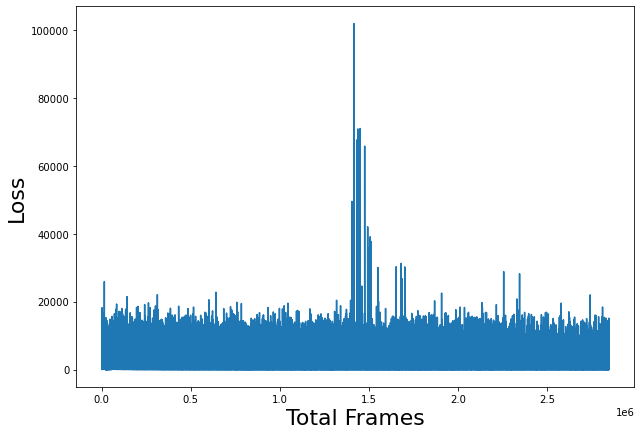

In [6]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Total Frames",fontsize=22)
plt.ylabel("Loss",fontsize=22)
plt.show()

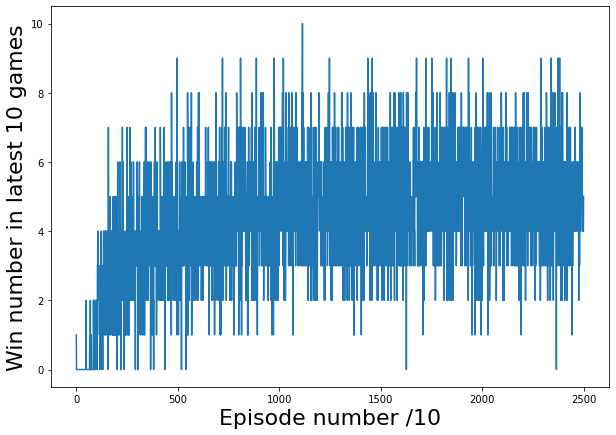

In [7]:
plt.figure(figsize=(10,7))
plt.plot(win_num_list)
plt.xlabel("Episode number /10",fontsize=22)
plt.ylabel("Win number in latest 10 games",fontsize=22)
plt.show()

In [8]:
model.save_weights('model_Double_DQN_dense_25000_episodes_Nov23.h5')


## Testing

In [9]:
model.load_weights('model_Double_DQN_dense_25000_episodes_Nov23.h5')

In [10]:
max_moves=250
def test_keras_model(model,display=True):
    clear_output(wait=True)
    i = 0
    test_game = Environment().initialize(4,4,0.2,True)[0]
    goldinPW = 1. if test_game.goldlocation == test_game.wumpuslocation or (test_game.goldlocation in test_game.pitlocations) else 0.
    stuck = 0
    die = 0
    winnogold = 0

    
    state_ = test_game.render_np().reshape(1,input_d) + np.random.rand(1,input_d)/100.0
    state = tf.convert_to_tensor(state_, dtype=float, dtype_hint=None, name=None)
    if display:
        print("Initial State:")
        print(test_game.visualize())
    status = 1
    while(status == 1):
        qval_ = model(state,training=False)
        action_ = np.argmax(qval_)
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.applyAction(action)
        state_ = test_game.render_np().reshape(1,input_d) + np.random.rand(1,input_d)/100.0
        state = tf.convert_to_tensor(state_, dtype=float, dtype_hint=None, name=None)
        if display:
            print(test_game.visualize())
        reward = test_game.agent.currentreward
        total_reward = test_game.agent.totalreward
        if test_game.terminated:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (test_game.agent.totalreward))
            else:
                if goldinPW and action=='Climb':
                    status = 2
                    winnogold += 1.
                    if display:
                        print("Game won! Reward: %s" % (test_game.agent.totalreward),"choose to climb out without gold")
                else:    
                    status = 0
                    die = 1
                    if display:
                        print("Game LOST. Reward: %s" % (test_game.agent.totalreward))
        i += 1
        if (i > max_moves):
            stuck=1
            if display:
                print("Game lost; too many moves.")
            break
   
    win = True if status == 2 else False
    pitnum = [0,0,0,0,0]
    win_in_pitnum = [0,0,0,0,0]
    num_of_pits = len(test_game.pitlocations)
    if num_of_pits == 0:
        pitnum[0]=1.
        if win:
            win_in_pitnum[0]=1.
    if num_of_pits == 1:
        pitnum[1]=1.
        if win:
            win_in_pitnum[1]=1.
    if num_of_pits == 2:
        pitnum[2]=1.
        if win:
            win_in_pitnum[2]=1.
    if num_of_pits == 3:
        pitnum[3]=1.
        if win:
            win_in_pitnum[3]=1.
    if num_of_pits >= 4:
        pitnum[4]=1.
        if win:
            win_in_pitnum[4]=1.
#     print("Reward:", test_game.agent.totalreward, win,action)
#     print(test_game.visualize())
    return win,total_reward,goldinPW,stuck,die,np.array(pitnum),np.array(win_in_pitnum),winnogold

In [16]:
# sample game
test_keras_model(model,display=True)

Initial State:
    |    |    |    
    |P   |    |W   
    |    |G   |    
A   |    |    |    

Move #: 0; Taking action: Forward
    |    |    |    
    |P   |    |W   
    |    |G   |    
    |A   |    |    

Move #: 1; Taking action: TurnLeft
    |    |    |    
    |P   |    |W   
    |    |G   |    
    |A   |    |    

Move #: 2; Taking action: Forward
    |    |    |    
    |P   |    |W   
    |A   |G   |    
    |    |    |    

Move #: 3; Taking action: TurnRight
    |    |    |    
    |P   |    |W   
    |A   |G   |    
    |    |    |    

Move #: 4; Taking action: TurnRight
    |    |    |    
    |P   |    |W   
    |A   |G   |    
    |    |    |    

Move #: 5; Taking action: Forward
    |    |    |    
    |P   |    |W   
    |    |G   |    
    |A   |    |    

Move #: 6; Taking action: TurnLeft
    |    |    |    
    |P   |    |W   
    |    |G   |    
    |A   |    |    

Move #: 7; Taking action: Forward
    |    |    |    
    |P   |    |W   
    |    |G   |    

(True,
 983,
 0.0,
 0,
 0,
 array([0., 1., 0., 0., 0.]),
 array([0., 1., 0., 0., 0.]),
 0)

In [12]:
max_games = 1000
wins = 0
reward = 0
goldinpwtotal = 0
stucktotal = 0
dietotal = 0
winnogoldtotal = 0
pitnumtotal = np.array([0,0,0,0,0])
winpitnumtotal = np.array([0,0,0,0,0])

for i in range(max_games):
    print('currently playing game:',i+1)
    win,treward,goldinpw,stuck,die,pitnum,winpitnum,winnogold = test_keras_model(
        model, display=False)
    reward += treward
    goldinpwtotal += goldinpw
    dietotal += die
    stucktotal += stuck
    pitnumtotal = pitnumtotal+pitnum
    winpitnumtotal = winpitnumtotal + winpitnum
    winnogoldtotal += winnogold
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
avg_reward = reward/max_games
print("Games played: {0}, number of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))
print("Average reward: {}".format(avg_reward))
print("Games with gold in pits/wumpus: {0}, win rate in other games: {1}".format(goldinpwtotal,wins/(max_games-goldinpwtotal)))
print("Games stuck: {}, games died: {}".format(stucktotal,dietotal))
print("Games with pits number 0,1,2,3 and 4+: {}, win numbers in those games: {}, win ratio: {}".format(pitnumtotal,
                                                                                                        winpitnumtotal,
                                                                                                        winpitnumtotal/pitnumtotal))
print("Climb out without gold: {}, ratio: {}".format(winnogoldtotal, winnogoldtotal/goldinpwtotal))

Games played: 1000, number of wins: 467
Win percentage: 46.7%
Average reward: 307.938
Games with gold in pits/wumpus: 292.0, win rate in other games: 0.6596045197740112
Games stuck: 515, games died: 18
Games with pits number 0,1,2,3 and 4+: [154. 279. 276. 196.  95.], win numbers in those games: [135. 174.  92.  50.  16.], win ratio: [0.87662338 0.62365591 0.33333333 0.25510204 0.16842105]
Climb out without gold: 0, ratio: 0.0


Text(0, 0.5, 'Winning rate')

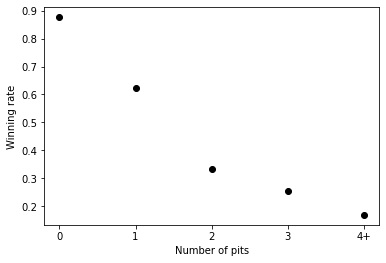

In [13]:
plt.plot(['0','1','2','3','4+'], winpitnumtotal/pitnumtotal, 'o', color='black')
plt.xlabel('Number of pits')
plt.ylabel('Winning rate')

## Discussion:
There are three(3) changes to the example code provided for this assignment.\
a. Modified the training step to use the Double DQN algorithm(Deepmind 2015 research paper) instead of the original DQN 
   algorithn used in the example code. \
b. Trained the model for 25,000 epochs.\
c. Reduced the model input from 78 to 72.


#### Average reward: 308
The model performed better than the example code with an average reward of 308. The example code has an average reward of 277.


